In [1]:
import filmic
import skimage.io as skio
import cv2
from PIL import Image

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: dummy                         	[default: None]
             dataset_mode: single                        	[default: unaligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_i

/Users/yahyarahhawi/Developer/Film/pytorch-CycleGAN-and-pix2pix/filmic.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_locatio

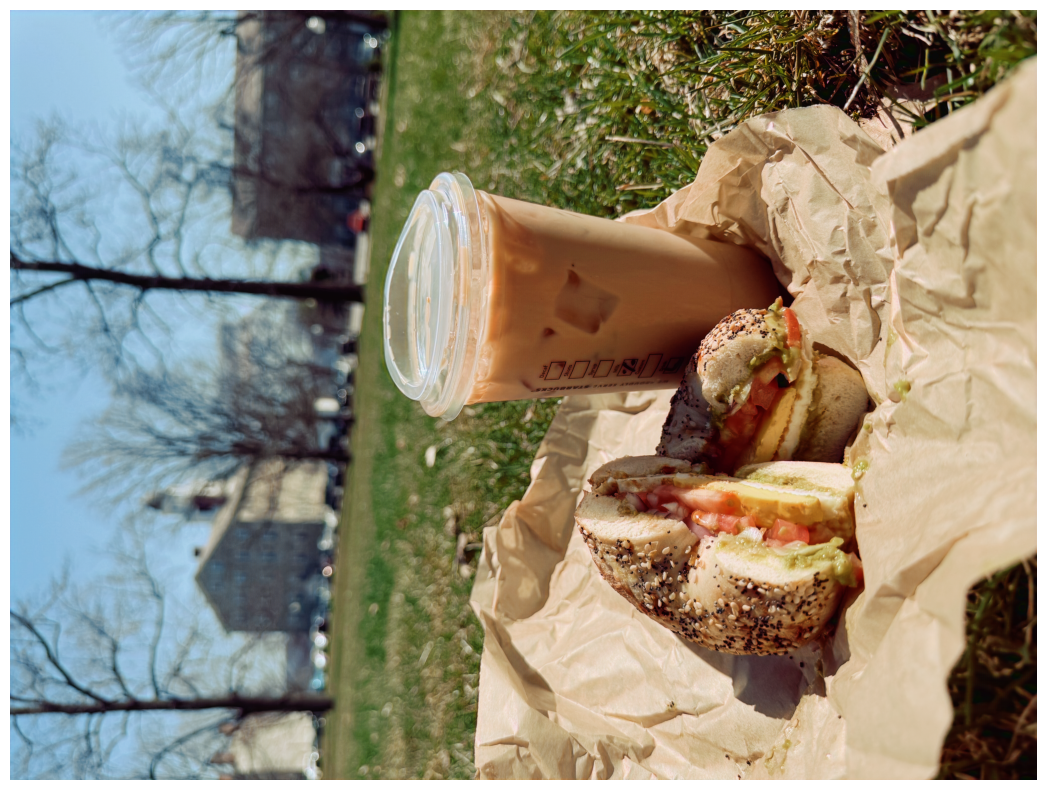

In [7]:
img_path = "/Users/yahyarahhawi/Developer/Film/pytorch-CycleGAN-and-pix2pix/datasets/film_transfer/trainA/IMG_1975.jpeg"
weights_path = "/Users/yahyarahhawi/Developer/Film/weights/portra/80_net_G_A.pth"
img = filmic.film(img_path,weights_path, 2048)
skio.imsave("a_test.jpg", img)

In [8]:
def inspect_video(
    video_path, weights_path, resize_to=2048, lum=False, max_frames=-1, output_path="processed_video.mov"
):
    """
    Reads a video from 'video_path', processes each frame using the 'film(...)' pipeline,
    and saves the processed video to 'output_path' in .MOV format with H.264 codec at 15 Mbps.

    :param video_path:  Path to the input video file (e.g. 'input.mp4').
    :param weights_path: Path to your CycleGAN netG_A weights (e.g. '15_net_G_A.pth').
    :param resize_to:   Resolution to use inside CycleGAN (default=2048 in this example).
    :param lum:         If True, 'film(...)' will return only the direct cycleGAN output.
    :param max_frames:  Number of frames to process. If -1, processes the entire video.
    :param output_path: Path to save the processed video (e.g. 'processed_video.mov').
    """
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error: could not open video {video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Use H.264 codec for .MOV format
    fourcc = cv2.VideoWriter_fourcc(*'H264')  # H.264 codec

    # Create VideoWriter with a high bitrate (15 Mbps)
    bitrate = 15000 * 1000  # 15 Mbps in bits per second
    out = cv2.VideoWriter(
        output_path,
        fourcc,
        fps,
        (width, height),
        isColor=True
    )

    frame_count = 0
    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            break  # No more frames or failed to read

        # 1) Convert BGR (OpenCV) to RGB (PIL expects RGB)
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        # 2) Convert to PIL Image
        frame_pil = Image.fromarray(frame_rgb)

        # 3) Apply your 'film(...)' pipeline
        processed_rgb = filmic.film(frame_pil, weights_path, resize_to=resize_to, lum=lum)

        # 4) Convert processed result (RGB) back to BGR for OpenCV
        processed_bgr = cv2.cvtColor(processed_rgb, cv2.COLOR_RGB2BGR)

        # 5) Write the processed frame to the output video
        out.write(processed_bgr)

        frame_count += 1
        # If max_frames is set and reached, stop processing
        if max_frames != -1 and frame_count >= max_frames:
            print(f"Processed max_frames={max_frames}, stopping.")
            break

    cap.release()
    out.release()
    print(f"Processed video saved to {output_path}")

In [ ]:
# Process the entire video and save it as 'processed_video.mp4' in the root directory
inspect_video(
    video_path="/Users/yahyarahhawi/Downloads/IMG_0105.MOV",
    weights_path=weights_path,
    resize_to=1024,
    max_frames=-1,
    output_path="processed_video2.mov"  # Save to root directory
)